# Time Series Modeling Notes 

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 

from datetime import datetime 
from sklearn.metrics import mean_squared_error 
from math import sqrt 
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns 
from pandas.plotting import register_matplotlib_converters 

import statsmodels.api as sm 
from statsmodels.tsa.api import Holt 

import env 
import acquire 
import prepare

In [2]:
#saas data 
df = pd.read_csv('saas.csv')

In [3]:
#no null values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [4]:
df['date'] = pd.to_datetime(df.Month_Invoiced)
df

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount,date
0,2014-01-31,1000000,5000000,0.0,0.0,2014-01-31
1,2014-01-31,1000001,5000001,2.0,10.0,2014-01-31
2,2014-01-31,1000002,5000002,0.0,0.0,2014-01-31
3,2014-01-31,1000003,5000003,0.0,0.0,2014-01-31
4,2014-01-31,1000004,5000004,1.0,5.0,2014-01-31
...,...,...,...,...,...,...
790453,2017-12-31,1029395,5790453,0.0,0.0,2017-12-31
790454,2017-12-31,1029396,5790454,0.0,0.0,2017-12-31
790455,2017-12-31,1029397,5790455,3.0,15.0,2017-12-31
790456,2017-12-31,1029398,5790456,0.0,0.0,2017-12-31


In [7]:
df = df.groupby(['date']).Amount.sum().reset_index()

In [8]:
df = df.set_index('date').sort_index()

### Split data (train/validate/test) and resample by any period except daily. Aggregate using the sum.

In [9]:
#Train set at 50% of data 
train_size = int(len(df) * 0.5)
#Validate set at 30% of data 
validate_size = int(len(df) * 0.3)
#Test size set at 20% of data
test_size = int(len(df) - train_size - validate_size)
#determine end of validate 
validate_end_index = train_size + validate_size 

#split into train, validate, test 
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [10]:
len(df) == len(train) + len(validate) + len(test)

True

In [11]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,Amount
date,
2017-02-28,53440.0
2017-03-31,53480.0


In [12]:
pd.concat([test.tail(1), df.tail(1)])

,Amount
date,
2017-12-31,53805.0
2017-12-31,53805.0


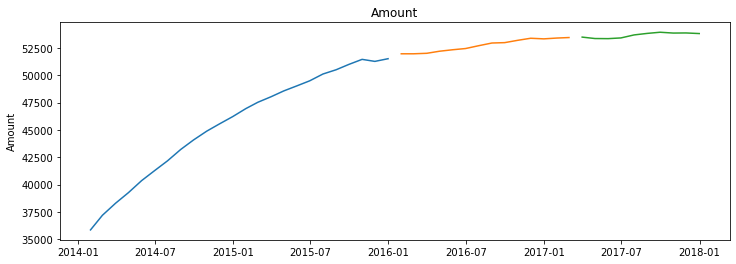

In [13]:
for col in train.columns: 
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

In [16]:
eval_df = pd.DataFrame(columns =['model_type', 'target_var', 'rmse'])

In [21]:
#functions 
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse 

def plot_and_eval(target_var):
    plt.figure(figsize = (12, 4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '--RMSE: {:.0f}'.format(rmse))
    plt.show()
    
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

def make_predictions():
    yhat_df = pd.DataFrame({'Amount': [amounts], 
                           }, index = validate.index)
    return yhat_df

### Simple Average 

In [22]:
amounts = round(train['Amount'].mean(),2)

In [23]:
yhat_df = make_predictions()

Amount --RMSE: 7181


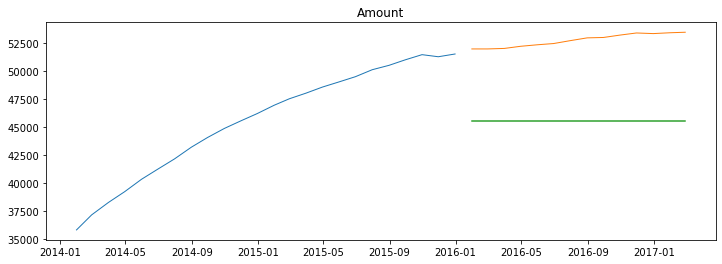

In [24]:
for col in train.columns: 
    plot_and_eval(col)

In [25]:
for col in train.columns: 
    eval_df = append_eval_df(model_type= 'simple_average', target_var = col)
    
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,7181.0


### Moving Average 

In [26]:
period = 2 

amounts = round(train['Amount'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,Amount
date,
2016-01-31,51382.5
2016-02-29,51382.5
2016-03-31,51382.5


Amount --RMSE: 1455


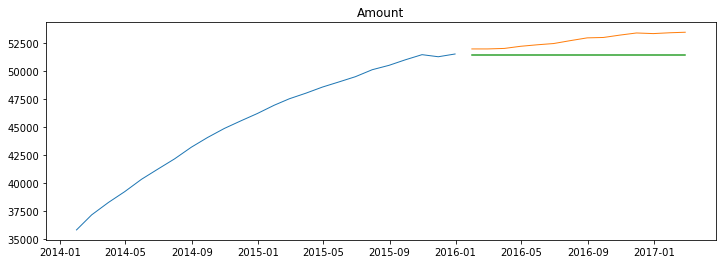

In [27]:
for col in train.columns:
    plot_and_eval(col)

In [28]:
for col in train.columns: 
    eval_df = append_eval_df(model_type= '2 Month Moving Average', 
                            target_var = col)

In [29]:
periods = [3, 4, 5, 6, 8, 12]

for p in periods: 
    amounts = round(train['Amount'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'month moving average'
    eval_df = append_eval_df(model_type = model_type, 
                            target_var = 'Amount')

In [30]:
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,7181.0
1,2 Month Moving Average,Amount,1455.0
2,3month moving average,Amount,1436.0
3,4month moving average,Amount,1533.0
4,5month moving average,Amount,1684.0
5,6month moving average,Amount,1847.0
6,8month moving average,Amount,2259.0
7,12month moving average,Amount,3164.0


In [31]:
min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]

In [32]:
eval_df[((eval_df.rmse == min_rmse_amount))]

,model_type,target_var,rmse
2,3month moving average,Amount,1436.0


### Holt's Linear Trend Model 

Amount 



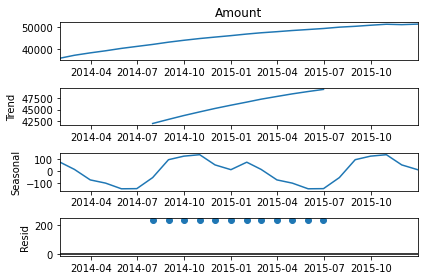

In [33]:
for col in train.columns: 
    print(col, '\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

In [34]:
for col in train.columns: 
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

Amount --RMSE: 8103


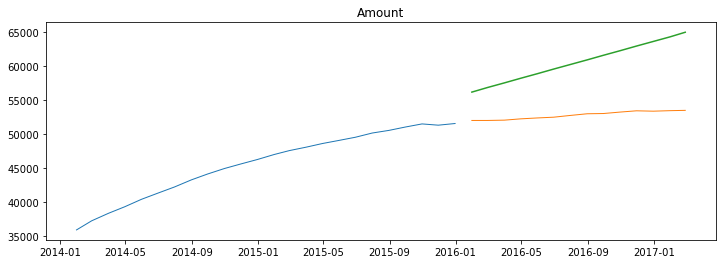

In [35]:
for col in train.columns: 
    plot_and_eval(target_var = col)

In [36]:
for col in train.columns: 
    eval_df = append_eval_df(model_type = 'Holts', 
                            target_var = col)
    
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,7181.0
1,2 Month Moving Average,Amount,1455.0
2,3month moving average,Amount,1436.0
3,4month moving average,Amount,1533.0
4,5month moving average,Amount,1684.0
5,6month moving average,Amount,1847.0
6,8month moving average,Amount,2259.0
7,12month moving average,Amount,3164.0
8,Holts,Amount,8103.0


In [37]:
train= df[:'2015']
validate = df['2016']
test = df['2017']

In [38]:
yhat_df = round(train['2015'] + train.diff(1).mean(),2)

In [39]:
pd.concat([yhat_df.head(1), validate.head(1)])

,Amount
date,
2015-01-31,47625.65
2016-01-31,51955.00


In [40]:
yhat_df.index = validate.index 

len(yhat_df)

12

Amount --RMSE: 2539


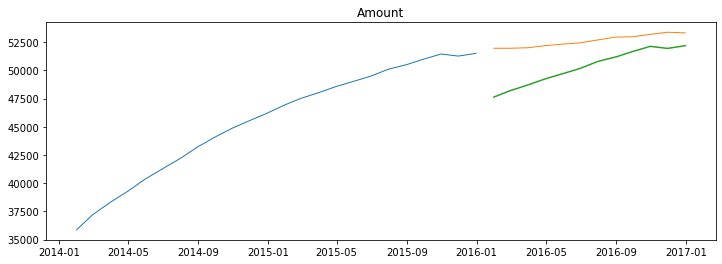

In [41]:
for col in train.columns: 
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

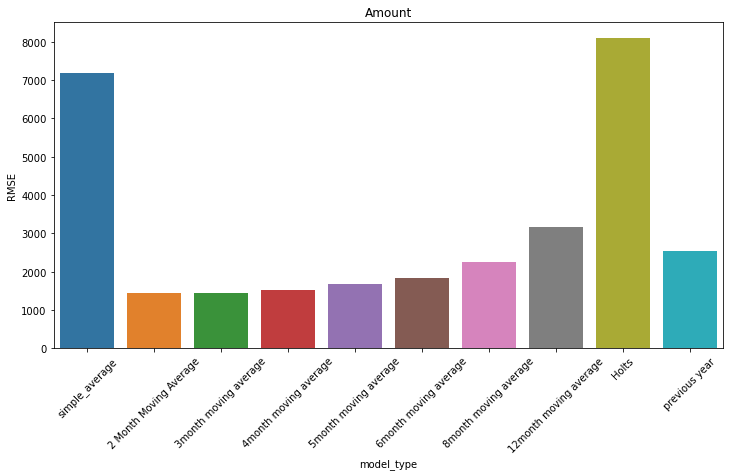

In [42]:
for col in train.columns: 
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show

In [43]:
yhat_df = validate + train.diff(1).mean()
yhat_df.index = test.index + pd.Timedelta('1Y')
yhat_df.head()

,Amount
date,
2018-01-31 05:49:12,52635.652174
2018-02-28 05:49:12,52635.652174
2018-03-31 05:49:12,52680.652174
2018-04-30 05:49:12,52870.652174
2018-05-31 05:49:12,53005.652174


In [44]:
rmse_amount = round(sqrt(mean_squared_error(test['Amount'], yhat_df['Amount'])), 0)

In [45]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12, 4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()
    

In [46]:
rmse_amount

463.0

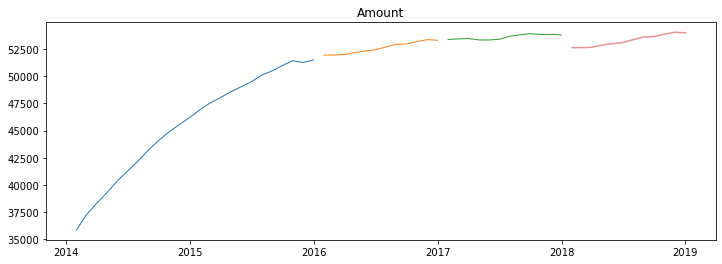

In [47]:
for col in train.columns: 
    plot_and_eval(col)